# 音源の再合成

In [28]:
#綺麗に描き直してユーティリティー関数に入れる

def scw_combain(x,duplicate_num=6):

    """波形を6つくっつけてSTFTする関数

    Args:
        x (torch.Tensor): single cycle wavetable
        duplicate_num (int, optional): 何個連結するか設定. Defaults to 6.
    Returns:
        tmp (torch.Tensor): six cycle wavetable
    """

    for i in range(duplicate_num):
        if i == 0:
            tmp = x
        else:
            tmp = torch.cat([tmp, x],dim=1)

    return tmp

def _scw2spectrum(x,duplicate_num=6):

    """波形を6つくっつけてSTFTする関数

    Args:
        x (torch.Tensor): [description]
        duplicate_num (int, optional): [description]. Defaults to 6.
    Returns:
        tmp (torch.Tensor): [description]
    """

    batch_size = len(x[:])
    for i in range(batch_size):
        single_channel_scw = x[i,:,:] #[32,1,600] -> [1,1,600]

        if i == 0:
            tmp = _scw_combain_spec(single_channel_scw,duplicate_num) #[901,1]
        else:
            tmp = torch.cat([tmp, _scw_combain_spec(single_channel_scw,duplicate_num)]) #[901*i,1]

    #combain_spec = tmp.reshape(batch_size,-1) # [32,901,1]??
    return tmp

再構成データのスペクトラム


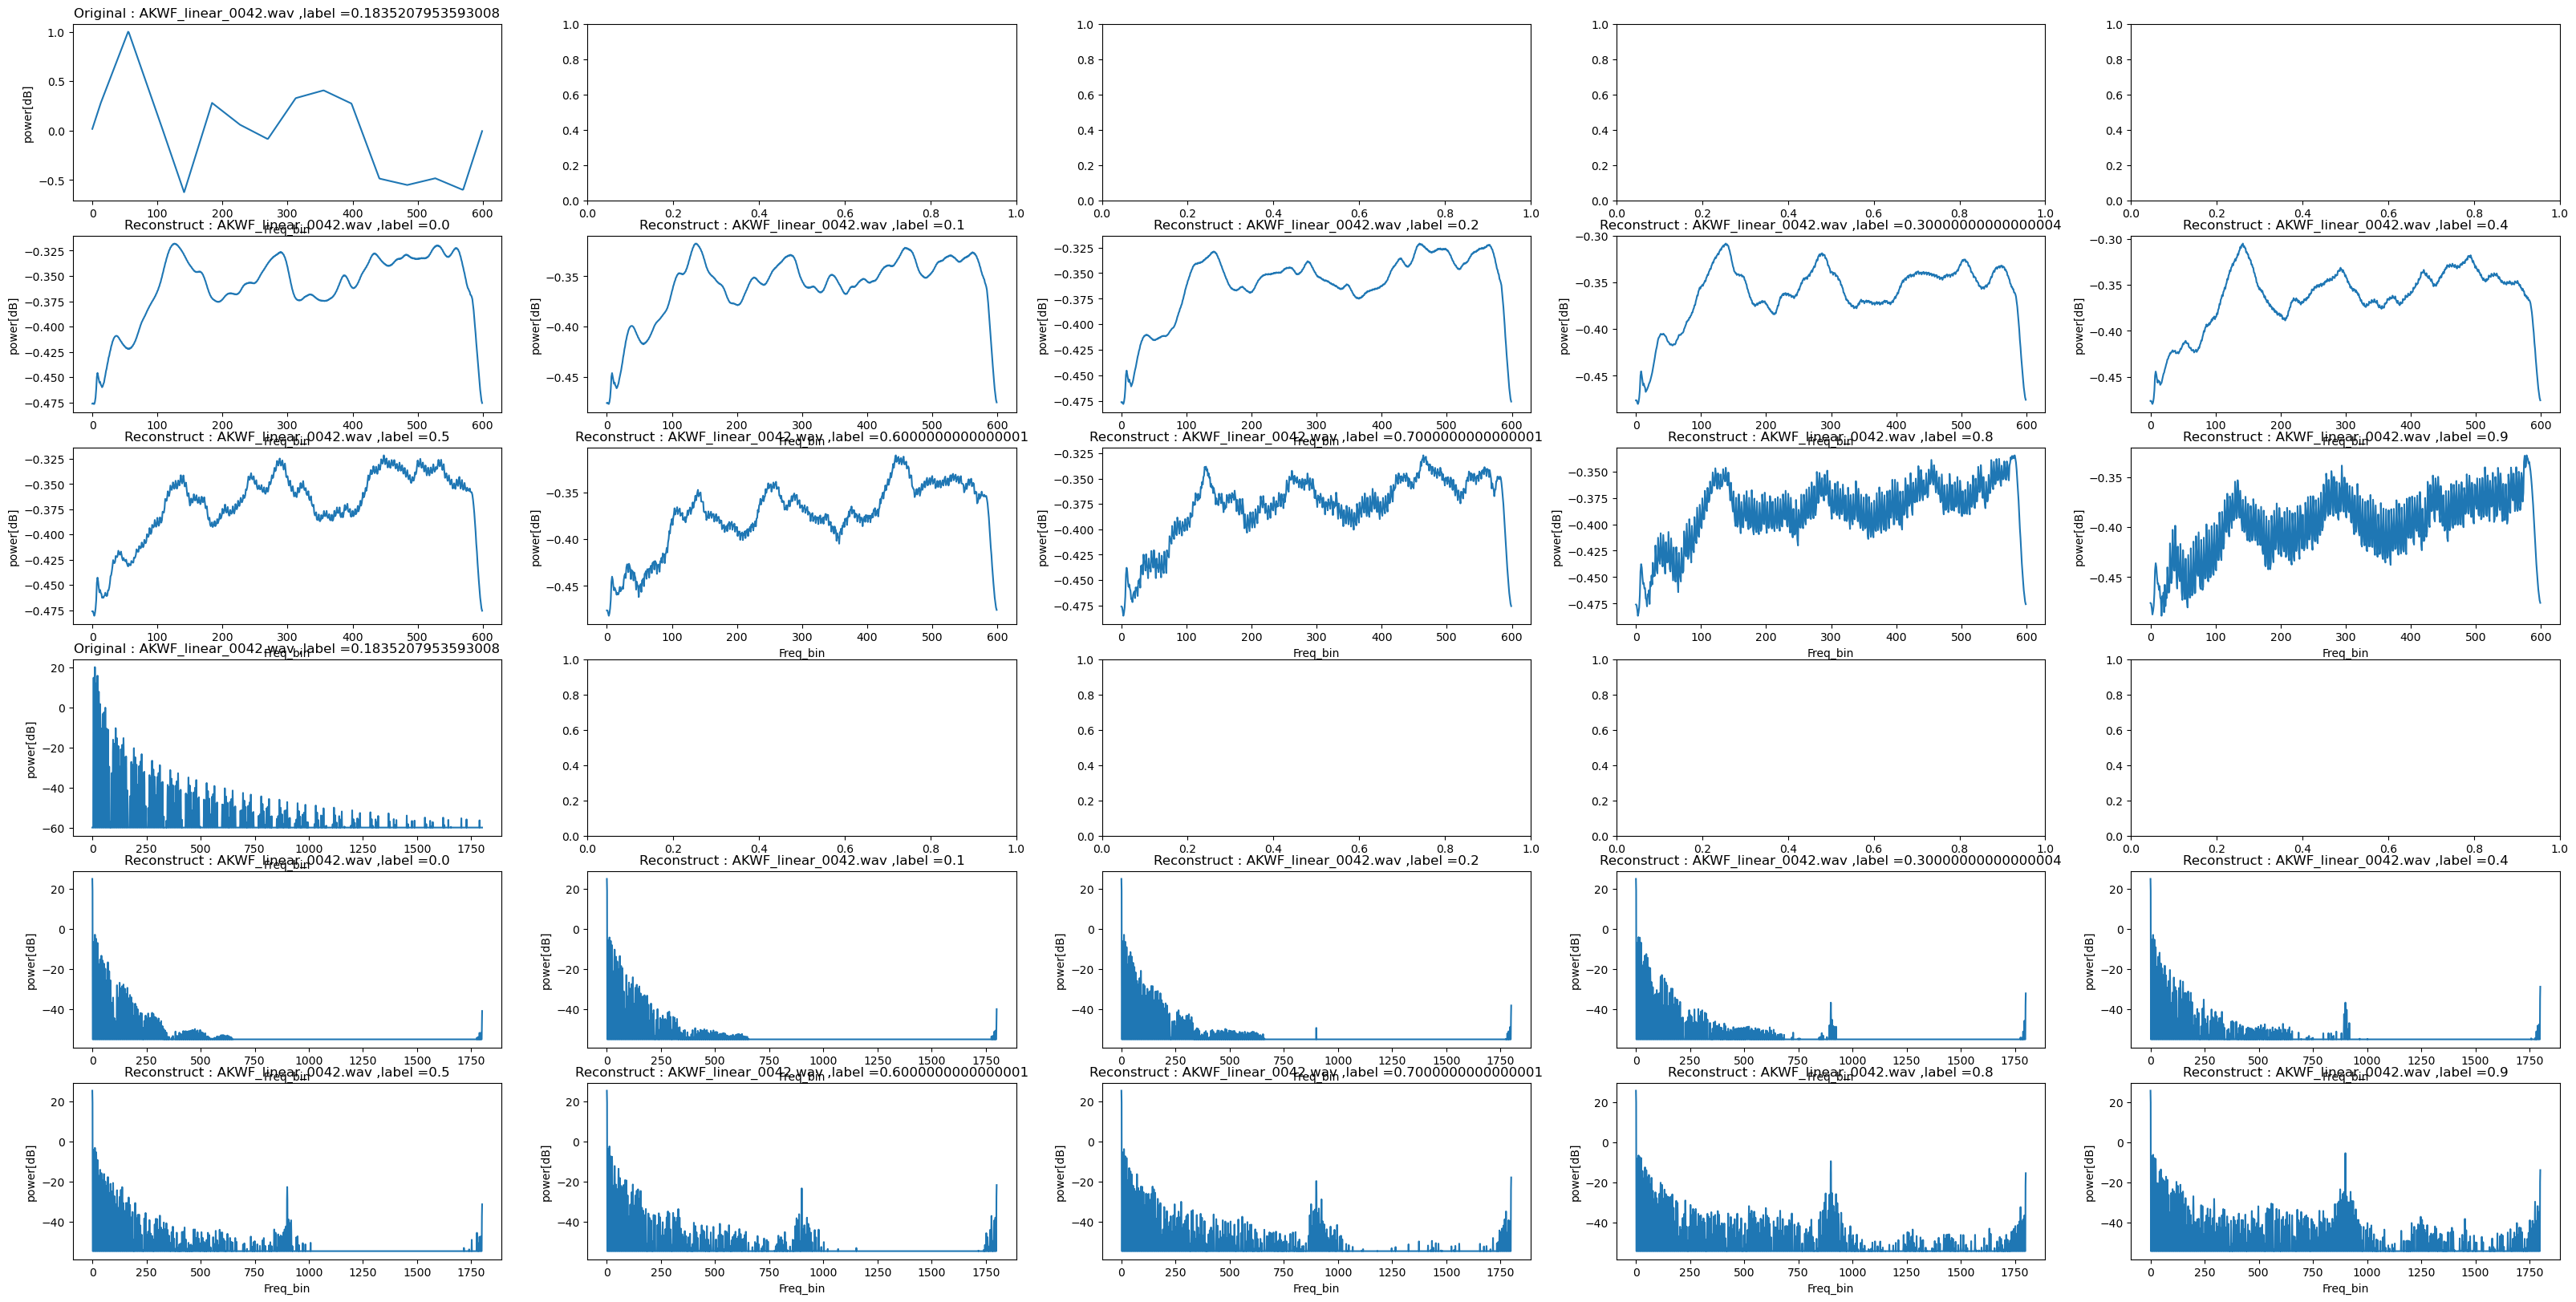

In [135]:
nrows = 4
ncols = 5
idx = 3

def plot_all(x,attrs,i,me):
  axs[i//ncols, i%ncols].set_title( me + " : " + attrs['name'] + " ,label =" + str(attrs['SpectralCentroid']))
  axs[i//ncols, i%ncols].set_xlabel("Freq_bin")
  axs[i//ncols, i%ncols].set_ylabel("power[dB]")
  axs[i//ncols, i % ncols].plot(x.cpu())


# 再構成した明るさを変えていく
fig, axs = plt.subplots(nrows=nrows+2, ncols=ncols, figsize=(40,20))
fig.patch.set_facecolor("white")
for i in range(10):
  if i >= 10: break
  else:
    if i == 0:
      x, attrs = dm.train_dataset[idx]
      me = "Original"
      plot_all(x[0],attrs,i,me)
      x = _scw_combain_spec(x,6)[0]
      plot_all(x,attrs,i+15,me)

    x, attrs = dm.train_dataset[idx]
    #attrs['brightness'] = (100 / 10) * i
    attrs['SpectralCentroid'] = (1 / 10) * i
    me = "Reconstruct"
    x = x.unsqueeze(0)
    _, _, x = model_eval(x,attrs,model,latent_op)
    plot_all(x[0,0],attrs,i+5,me)
    x = _scw_combain_spec(x,6)[0]
    plot_all(x,attrs,i+20,me)

print("再構成データのスペクトラム")

## 確認用に簡易的なWavetable Synthを作ろう

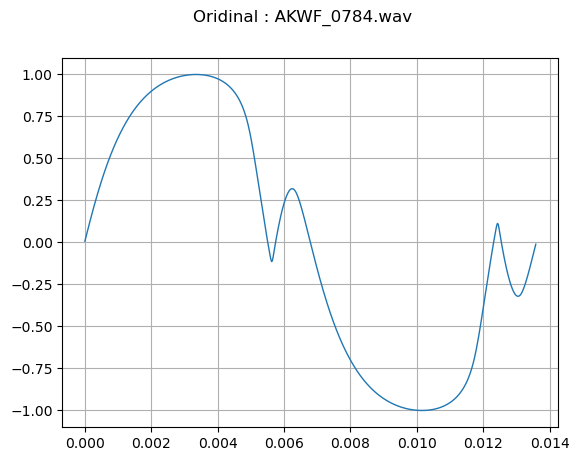

default_brightness 41.812464663505786
0


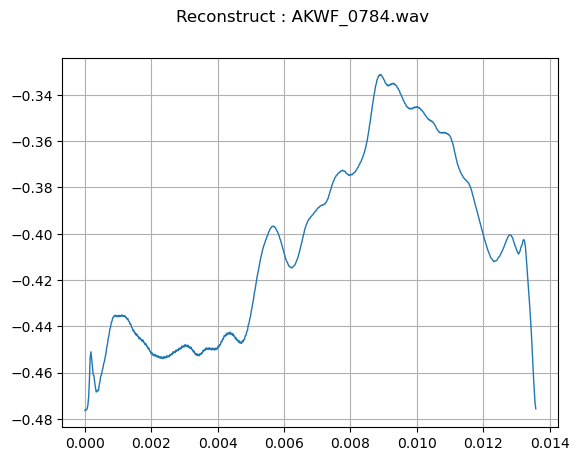

20


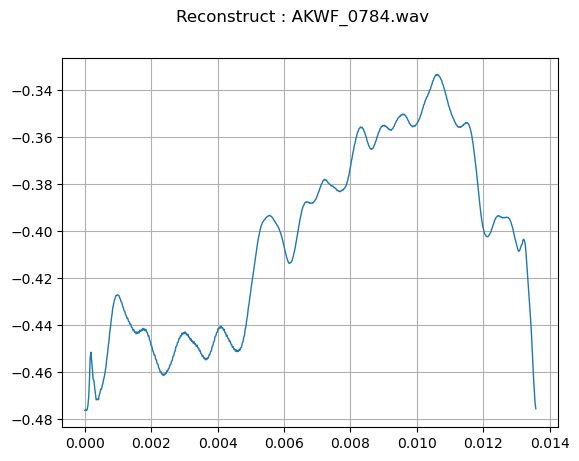

40


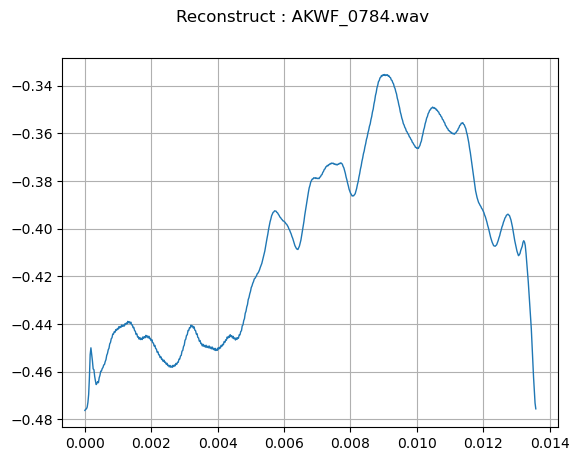

60


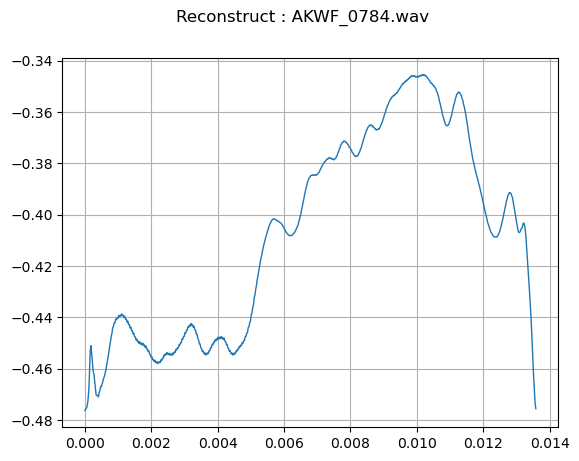

80


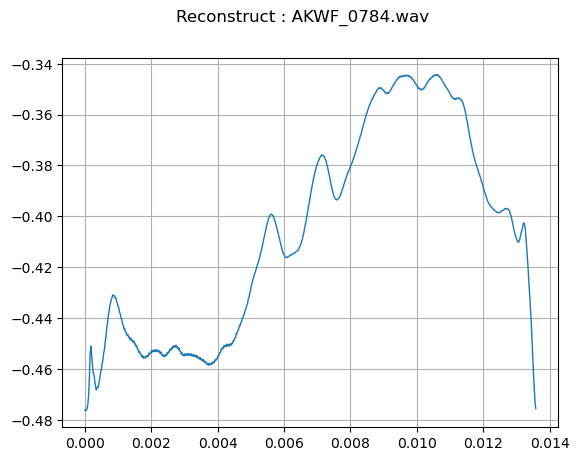

In [138]:
#wavetable, attrs = dm.test_dataset[random.randint(0,len(dm.train_dataset))]
wavetable, attrs = dm.test_dataset[0]
plot_waveform(wavetable, attrs["samplerate"], title="Oridinal : " + attrs["name"])
print("default_brightness",attrs['brightness'])

for i in np.arange(0, 100, 20):
    attrs['brightness'] = i
    #attrs['roughness'] = i
    #attrs['depth'] = i
    _, _, predict_wavetable = model_eval(wavetable.unsqueeze(0),attrs,model,latent_op)
    predict_wavetable = predict_wavetable.cpu()
    print(attrs['brightness'])
    plot_waveform(predict_wavetable[0], attrs["samplerate"], title="Reconstruct : " + attrs["name"])
    audio = wavetableSynth(predict_wavetable, sample_rate, duration, frequency, amplitude, start_phase)
    display(Audio(audio, rate=sample_rate))
    

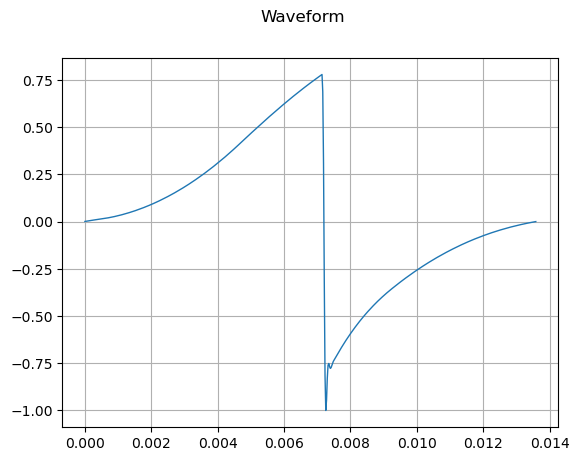

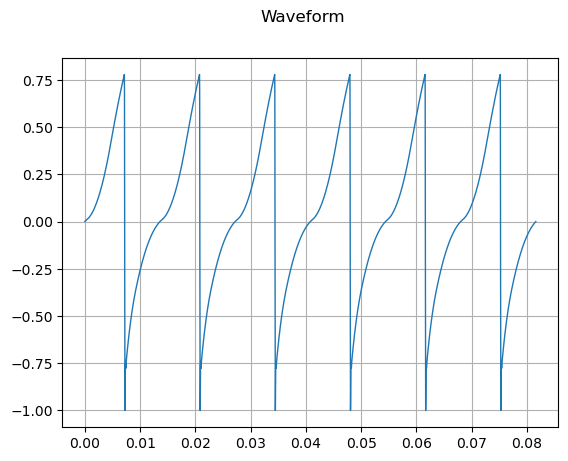

torch.Size([1, 3600])
torch.Size([1801, 1])
1


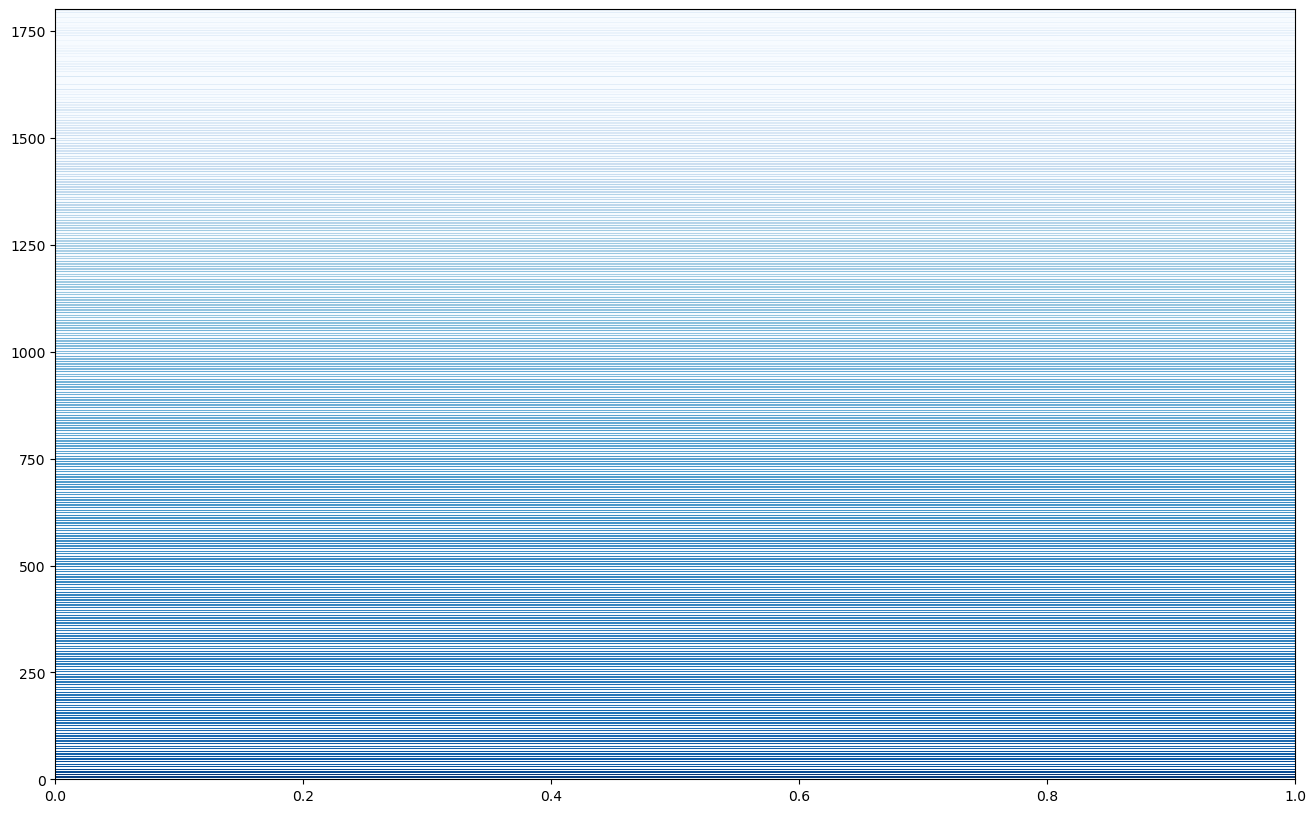

In [139]:
#ちゃんとどのような挙動になっているか確認する

# 波形を6つくっつけてSTFTする
copy_count = 6

#wavetable, attrs = dm.train_dataset[random.randint(0,len(dm.train_dataset))]
wavetable, attrs = dm.train_dataset[0]

#print(wavetable.shape)
plot_waveform(wavetable, attrs["samplerate"])

#wavetable = torch.randn(32,1,600)
#print(len(wavetable[:]))
#batch_size = len(wavetable[:])

#wavetable = wavetable.reshape(batch_size, -1)
# indices for the wavetable values; this is just for `np.interp` to work
wavetable_period = len(wavetable[0,:])

tmp_wavetable = wavetable

for i in range(copy_count-1):
    tmp_wavetable = torch.cat([tmp_wavetable,  wavetable])
    #print(i)
combain_wavetables = tmp_wavetable.reshape(1, -1)
plot_waveform(combain_wavetables, attrs["samplerate"])

print(combain_wavetables.shape)


spec = torchaudio.transforms.Spectrogram(
                                         n_fft = int(wavetable_period*(copy_count)),
                                         hop_length = int(wavetable_period*(copy_count)),
                                         win_length = int(wavetable_period*(copy_count)),
                                         center=False,
                                         pad=0,
                                         window_fn = torch.hann_window,
                                         normalized=True,
                                         onesided=True,
                                         #return_complex = True,
                                         power=2.0)

ToDB = torchaudio.transforms.AmplitudeToDB()


spec_wavetable = ToDB(spec(combain_wavetables).abs())
spec_wavetable =spec_wavetable[0]
print(spec_wavetable.shape)
print(len(spec_wavetable[0]))
#spec_wavetable = spec_wavetable[0,:901,1:-1]
#print(spec_wavetable.shape)

plt.figure(figsize=(16,10))
plt.pcolor(spec_wavetable, cmap=plt.cm.Blues)

In [140]:
import torch

def waveToSpec(waveform: torch.Tensor, sample_points: int, db:bool ):
    spec =  torchaudio.transforms.Spectrogram(
                                                       n_fft = sample_points, #時間幅
                                                       hop_length = sample_points, #移動幅
                                                       win_length = sample_points, #窓幅
                                                       center=False,
                                                       pad=0, #no_padding
                                                       window_fn = torch.hann_window,
                                                       normalized=True,
                                                       onesided=True,
                                                       power=1.0)
        
    ToDB =  torchaudio.transforms.AmplitudeToDB(stype = 'magnitude')#,top_db = 50)
    combain_x = waveform.reshape(1, -1) # [3600] -> [1,3600]
    spec_x = spec(combain_x.to('cpu')) # [1,3600] -> [901,1???]
    #print(spec_x.shape)
    if db:
        spec_x = ToDB(spec_x)

    return spec_x

In [141]:
import statistics
import Signal_Analysis.features.signal as signal
import essentia.standard as ess
import os

#インスタンス化
centroid = ess.Centroid()
centralMoments = ess.CentralMoments()
distributionShape = ess.DistributionShape()
zeroCrossingRate = ess.ZeroCrossingRate()
powerSpectrum = ess.PowerSpectrum(size=3600)

spectralPeaks = ess.SpectralPeaks()
spectalComplexity = ess.SpectralComplexity()
odd = ess.OddToEvenHarmonicEnergyRatio()
dissonance = ess.Dissonance()
pitchSalience = ess.PitchSalience()
ess_spectrum = ess.Spectrum(size=3600)

def ytn_audio_exatractor(audio: torch.Tensor):
    
    # 6つ繋げたWavetableを保存する
    torchaudio.save(filepath='tmp.wav', src=audio.to('cpu'), sample_rate=44100)
    # 読み込む
    ess_audio = ess.MonoLoader(filename='tmp.wav')()
    ess_spec = ess_spectrum(ess_audio)

    # 保存したファイルを削除する
    os.remove('tmp.wav')
    
    c = centroid(ess_spec)
    sp, _, k = distributionShape(centralMoments(ess_spec))

    z = zeroCrossingRate(ess_audio)
    sc = spectalComplexity(ess_spec)
    freq , mag = spectralPeaks(ess_spec)

    o = odd(freq, mag)
    d = dissonance(freq, mag)
    ps = pitchSalience(ess_spec)
    h = signal.get_HNR(ess_audio, attrs['samplerate'])

    return c,sp,k,z,sc,o,d,ps,h

ModuleNotFoundError: No module named 'essentia'

In [50]:
from scipy import stats
def ConditionLabelEval(label_name:str,normalize_method:str,dm_num:int=0,resolution_num:int=10,bias:int=1):
    wavetable, attrs = dm.train_dataset[dm_num]

    cond_label = []
    est_label = []

    #ラベルを段階的に設定
    for i in range(resolution_num+1):

        attrs[label_name] = (1/resolution_num)*i
        cond_label.append(attrs[label_name])
        attrs[label_name] =  attrs[label_name] * bias
        _, _, x = model_eval(wavetable.unsqueeze(0),attrs,model)
        #波形を6つ繋げる
        six_cycle_wavetable = scw_combain(x.squeeze(0),duplicate_num=6)
        est_label.append(est_label_eval(six_cycle_wavetable,label_name=label_name,dbFlg=False))

    #normalize
    est_label = Normalize(est_label,normalize_method=normalize_method,label_name=label_name)

    return cond_label,est_label

def ConditionLabelEvalPlt(label1,label2,label_name:str):  
    #折れ線グラフ表示
    p1 = plt.plot(label1,linewidth=2)
    p2 = plt.plot(label2,linewidth=2) #linestyle="dashed")

    plt.title(label_name)
    plt.xlabel("x axis")
    plt.ylabel("label value")
    plt.grid(True)

    plt.legend((p1[0], p2[0]), ("traget label", "estimate label"), loc=2)


def est_label_eval(wavetable:torch.Tensor,label_name:str, dbFlg:bool=False):
    #essentiaでの処理
    c,sp,k,z,sc,o,d,ps,h = ytn_audio_exatractor(wavetable)

    if label_name == "SpectralCentroid":
        est_data = c
    elif label_name == "SpectralSpread":
        est_data = sp
    elif label_name == "SpectralKurtosis":
        est_data = k
    elif label_name == "ZeroCrossingRate":
        est_data = z
    elif label_name == "SpectralComplexity":
        est_data = sc
    elif label_name == "OddToEvenHarmonicEnergyRatio":
        est_data = o
    elif label_name == "PitchSalience":
        est_data = ps
    elif label_name == "HNR":
        est_data = h
    else:
        raise Exception('Error!')
    
    return est_data

def min_max_for_list(list, l_min, l_max):
    return [((i - l_min) / (l_max - l_min)) for i in list]

def standardization(l):
    l_mean = statistics.mean(l)
    l_stdev = statistics.stdev(l)
    return [(i - l_mean) / l_stdev for i in l]

def min_max(data, min, max):
    return (data - min) / (max - min)

def Normalize(list,normalize_method:str,label_name):
    if normalize_method == "minmax":
        settings = {
            'c_min' : 0.002830265322700143,
            'c_max' :  0.6261523365974426,
            'sp_min' :  4.544603143585846e-05,
            'sp_max' :  0.1918134242296219,
            'k_min' :  -1.8175479173660278,
            'k_max' :  13452.046875,
            'z_min' :  0.0,
            'z_max' :  0.9397222399711609,
            'o_min' :  4.430869191517084e-13,
            'o_max' :  1000.0,
            'ps_min' :  2.086214863084024e-06,
            'ps_max' :  0.9996329545974731,
            'h_min' :  0,
            'h_max' :  81.83601217317359,
        }

        list = min_max_for_WT(list,label_name,settings)
    elif normalize_method == "yeojohnson":

        settings = {
            'centro_lmbda' : -10.148733692848015,
            'spread_lmbda' : -34.713344641365005,
            'kurtosis_lmbda' : -0.06085805654641739,
            'zeroX_lmbda' :  -86.95932559132982,
            'oddfreq_lmbda' : -0.4448269945442323,
            'pitchSali_lmbda' : 0.03215774267929409,
            'HNR_lmbda' : -0.6864951592316563,
        }

        list = yeojonson_for_WT(list,label_name,settings)

        settings = {
            'c_min' : 0.0027861194649845184,
            'c_max' :   0.09782558652904423,
            'sp_min' :  4.540917180699981e-05,
            'sp_max' :  0.02874219353637187,
            'k_min' :  -3.6174942560623955,
            'k_max' :  7.218490470781908,
            'z_min' :  -0.0,
            'z_max' :  0.011499629202502738,
            'o_min' :  4.4301400159600645e-13,
            'o_max' :  2.144040707985547,
            'ps_min' :  2.0862127571496856e-06,
            'ps_max' :  0.7007423659379493,
            'h_min' :  -0.0,
            'h_max' : 1.3864458576891578,
        }
        list = min_max_for_WT(list,label_name,settings)
    else:
        raise Exception('Error!') 

    return list

def min_max_for_WT(list,label_name:str,sett):

    if label_name == "SpectralCentroid":
        list = min_max_for_list(list,sett['c_min'],sett['c_max'])
    elif label_name == "SpectralSpread":
        list = min_max_for_list(list,sett['sp_min'],sett['sp_max'])
    elif label_name == "SpectralKurtosis":
        list = min_max_for_list(list,sett['k_min'],sett['k_max'])
    elif label_name == "ZeroCrossingRate":
        list = min_max_for_list(list,sett['z_min'],sett['z_max'])
    elif label_name == "OddToEvenHarmonicEnergyRatio":
        list = min_max_for_list(list,sett['o_min'],sett['o_max'])
    elif label_name == "PitchSalience":
        list = min_max_for_list(list,sett['ps_min'],sett['ps_max'])
    elif label_name == "HNR":
        list = min_max_for_list(list,sett['h_min'],sett['h_max'])
    else:
        raise Exception('Error!')
    return list

def yeojonson_for_WT(list,label_name:str,sett):

    if label_name == "SpectralCentroid":
        list = stats.yeojohnson(list,sett['centro_lmbda'])
    elif label_name == "SpectralSpread":
        list = stats.yeojohnson(list,sett['spread_lmbda'])
    elif label_name == "SpectralKurtosis":
        list = stats.yeojohnson(list,sett['kurtosis_lmbda'])
    elif label_name == "ZeroCrossingRate":
        list = stats.yeojohnson(list,sett['zeroX_lmbda'])
    elif label_name == "OddToEvenHarmonicEnergyRatio":
        list = stats.yeojohnson(list,sett['oddfreq_lmbda'])
    elif label_name == "PitchSalience":
        list = stats.yeojohnson(list,sett['pitchSali_lmbda'])
    elif label_name == "HNR":
        list = stats.yeojohnson(list,sett['HNR_lmbda'])
    else:
        raise Exception('Error!')
    return list

CentroidMAE : 5.8600971415281045
SpreadMAE : 7.169821569588526
KurtosisMAE : -3.143212229157868
ZeroXMAE : -7.500000000000001
OddMAE : -7.493294738740671
PsMAE : -7.190412042472046
HNRMAE : -2.8585273377113407


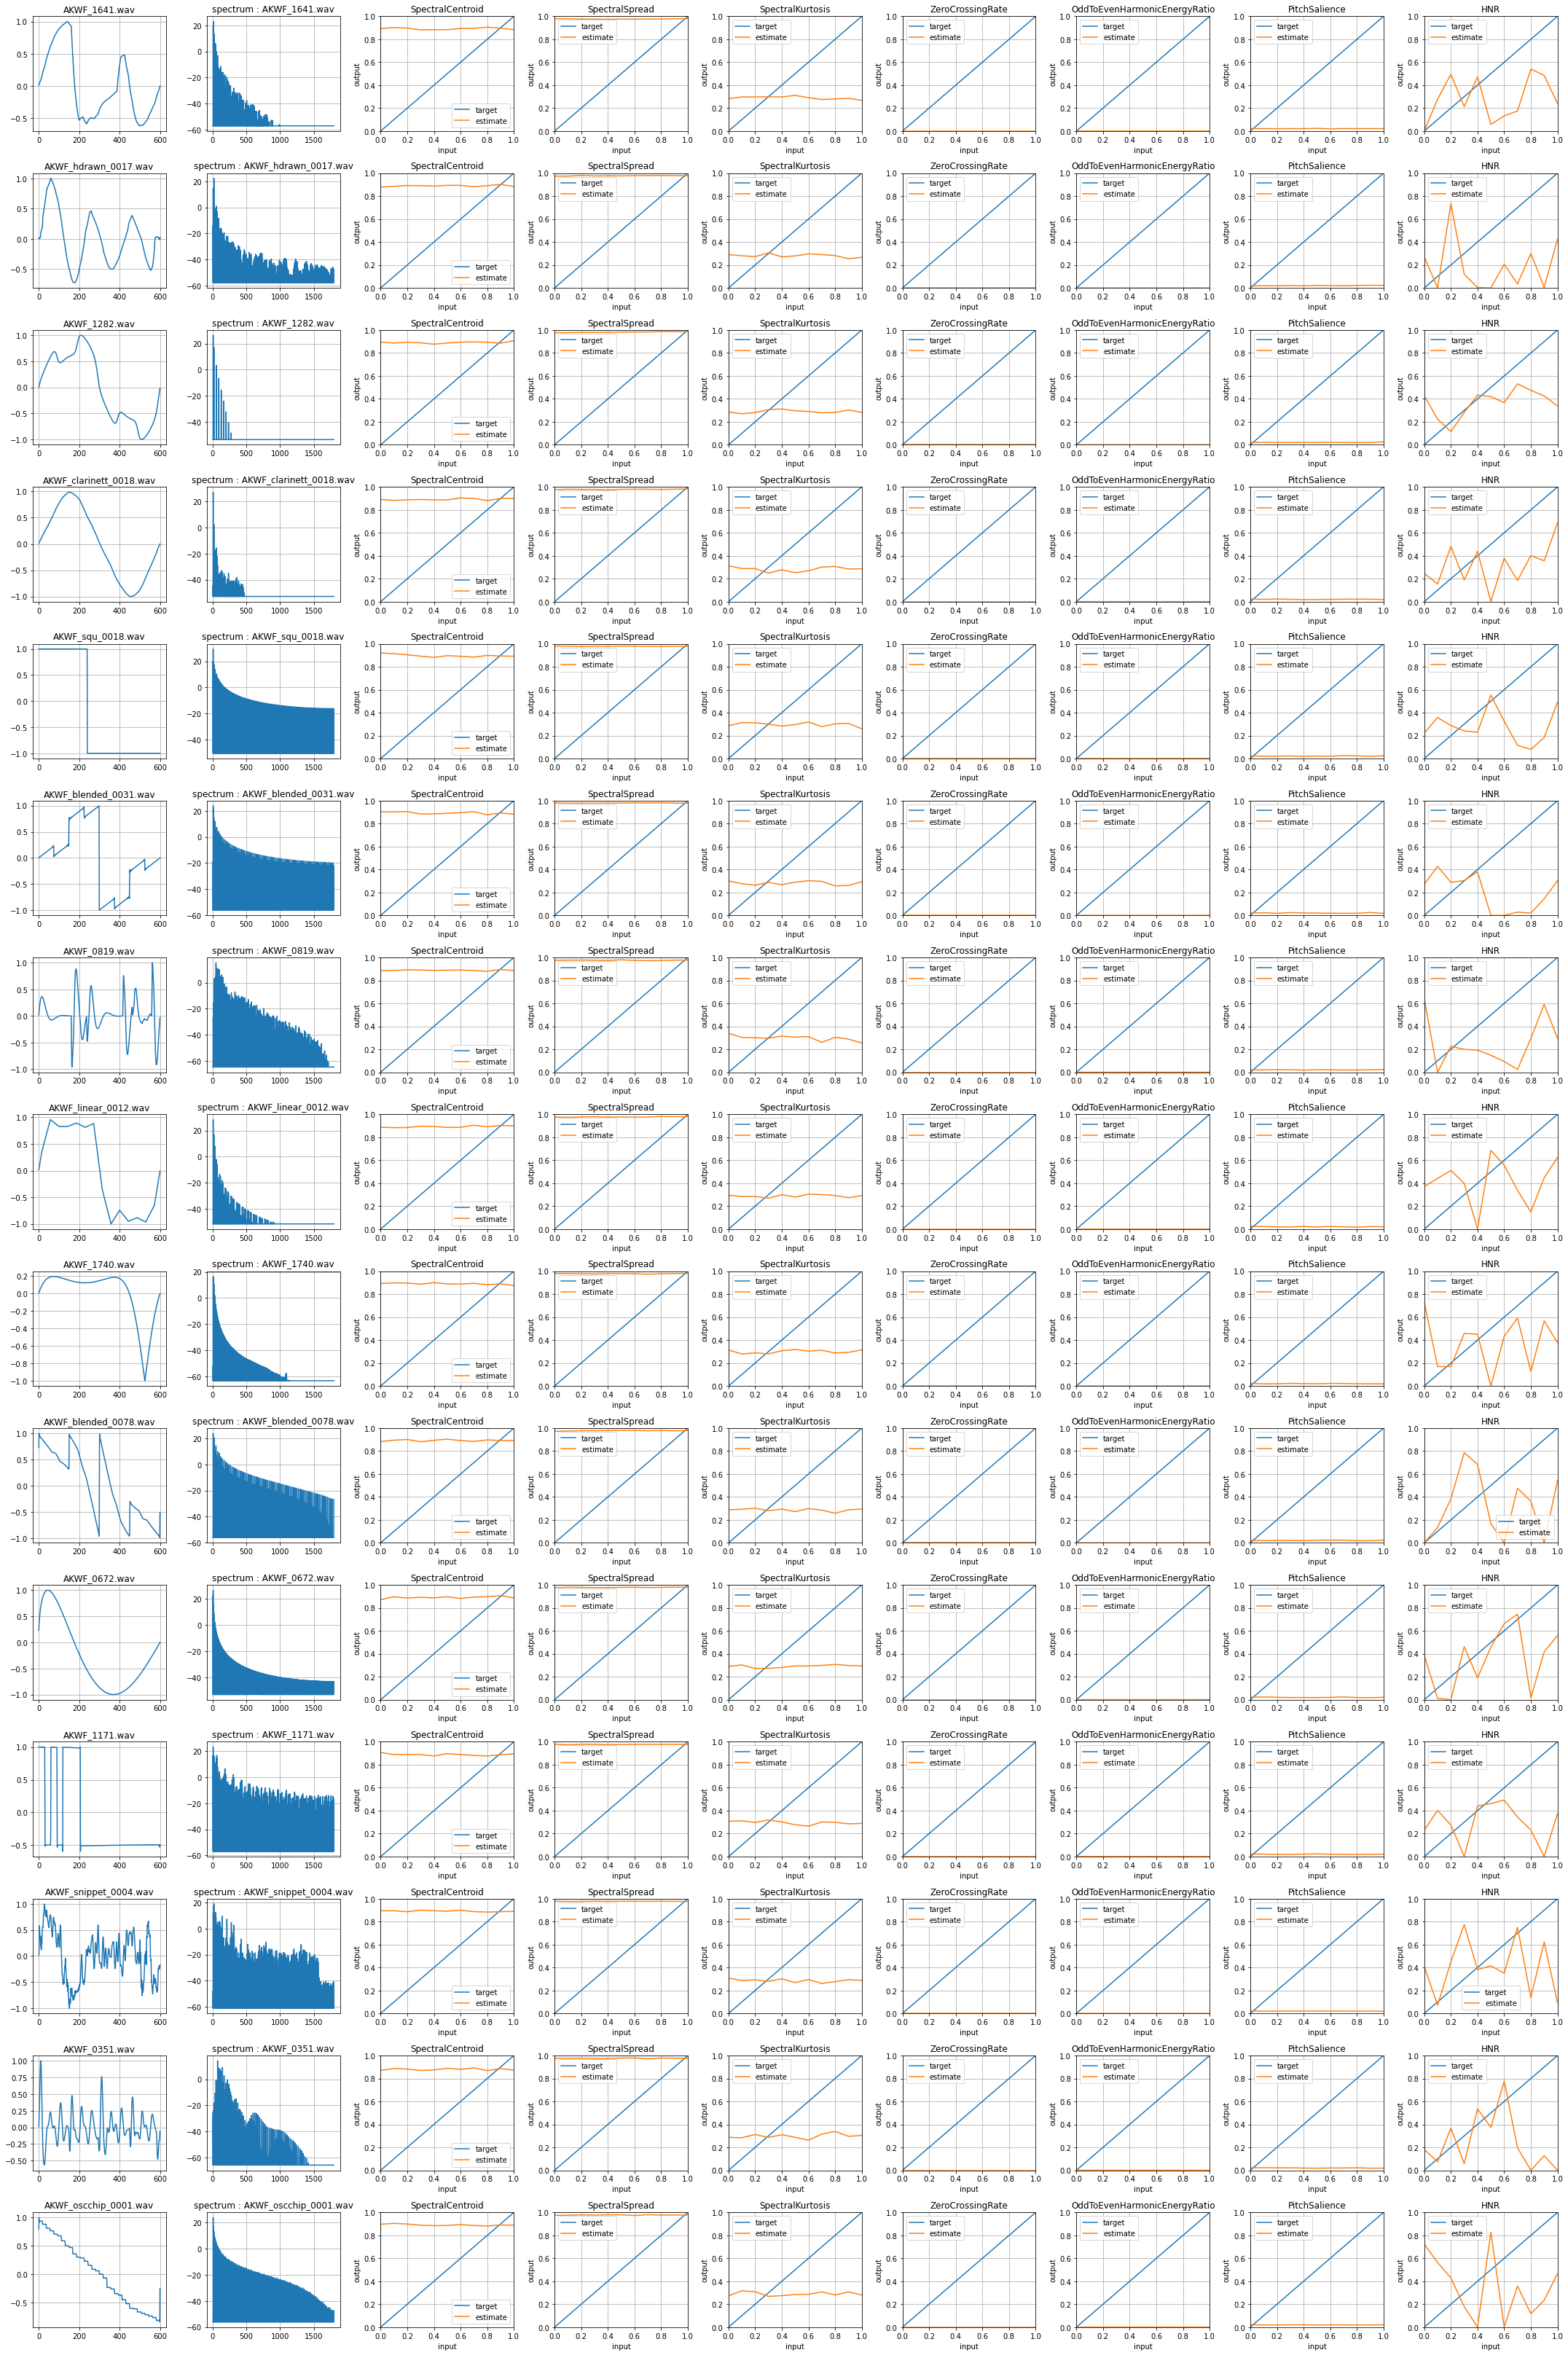

In [51]:
import statistics

attrs_label = ["SpectralCentroid","SpectralSpread","SpectralKurtosis","ZeroCrossingRate","OddToEvenHarmonicEnergyRatio","PitchSalience","HNR"]
dm_num = 15

fig, axes = plt.subplots(dm_num, len(attrs_label)+2,figsize=(30,3*dm_num),tight_layout=True)
resolution_num = 10
x = np.array(range(resolution_num+1)) / resolution_num

CentroidMAE = 0
SpreadMAE = 0
KurtosisMAE = 0
ZeroXMAE = 0
OddMAE = 0
PsMAE = 0
HNRMAE = 0

for j in range(dm_num):
    for i in range(len(attrs_label)+2):

        if i == 0:
            wavetable, attrs = dm.train_dataset[j]
            axes[j,i].plot(wavetable.squeeze(0))
            axes[j,i].set_title(attrs['name'])
            axes[j,i].grid(True)

        elif i == 1:
            spectrum = _scw_combain_spec(wavetable,6)[0]
            axes[j,i].plot(spectrum.squeeze(0))
            axes[j,i].set_title("spectrum : " +attrs['name'])
            axes[j,i].grid(True)

        else:
            target,estimate = ConditionLabelEval(attrs_label[i-2],normalize_method='yeojohnson', dm_num=j, resolution_num=resolution_num, bias=1)

            axes[j,i].set_title(attrs_label[i-2])
            axes[j,i].grid(True)
            axes[j,i].plot(x,target, label="target")
            axes[j,i].plot(x,estimate, label="estimate")
            axes[j,i].set_xlim(0, 1)
            axes[j,i].set_ylim(0, 1)
            axes[j,i].set_xlabel("input", size=10)
            axes[j,i].set_ylabel("output", size=10)
            axes[j,i].legend()

            if i == 2:

                CentroidMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 3:
                SpreadMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 4:
                KurtosisMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 5:
                ZeroXMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 6:
                OddMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 7:
                PsMAE += np.mean(np.array(estimate)-np.array(target))
            elif i == 8:
                HNRMAE += np.mean(np.array(estimate)-np.array(target))

print("CentroidMAE :",CentroidMAE)
print("SpreadMAE :",SpreadMAE)
print("KurtosisMAE :",KurtosisMAE)
print("ZeroXMAE :",ZeroXMAE)
print("OddMAE :",OddMAE)
print("PsMAE :",PsMAE)
print("HNRMAE :",HNRMAE)

plt.show()